In [30]:
from lib.rendering.renderer import SignedDistanceFunction, Camera, Light, Scene, SphereTracer
from lib.models.siamese import Siamese
import torch

ckpt_path = "/Users/robinborth/Code/sketch2shape/logs/last.ckpt"
sdf = SignedDistanceFunction(ckpt_path=ckpt_path, obj_idx=34)
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
sphere_tracer = SphereTracer(max_steps=500, warm_step_scale=1)
scene = Scene(sdf=sdf, camera=camera, light=light, sphere_tracer=sphere_tracer)

61


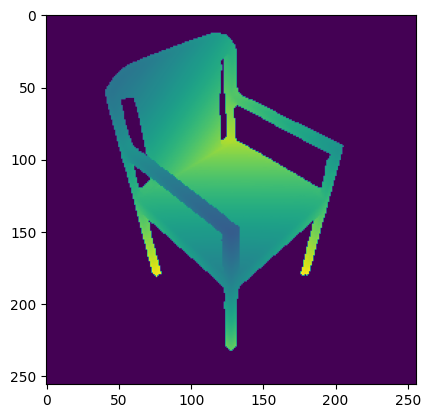

In [31]:
from lib.rendering.utils import visualize_depth

depth = scene.render_depth() 
visualize_depth(depth)

61


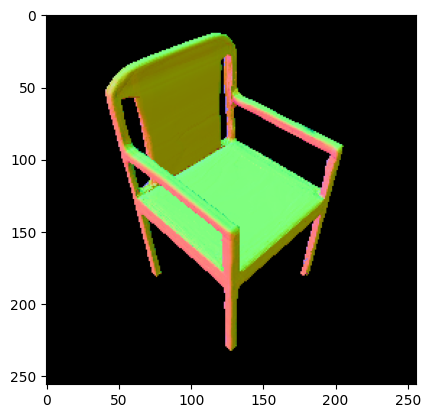

In [22]:
from lib.rendering.utils import visualize_normals

normals, _ = scene.render_normals()
visualize_normals(normals)

61


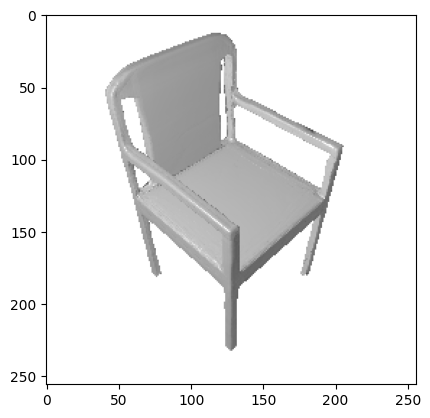

In [29]:
from lib.rendering.utils import visualize_image

image = scene.render_image()
visualize_image(image)

In [32]:
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from lib.models.siamese import Siamese

import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.rendering.renderer import SignedDistanceFunction, Camera, Light, Scene, SphereTracer

sdf_ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
siamese_ckpt_path = "/home/borth/sketch2shape/logs/save/siamese/checkpoints/last.ckpt"
sketch_path = "/home/borth/sketch2shape/data/siamese_chair_large/96d9944f46bd330979414e04132a8bef/sketches/00021.jpg"

# siamese = Siamese.load_from_checkpoint(siamese_ckpt_path)
sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
sdf.lat_vec = sdf.lat_vec + torch.randn(sdf.lat_vec.shape).to("cpu")
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
scene = Scene(sdf=sdf, camera=camera, light=light)
optimizer = Adam(sdf.model.parameters(), lr=1e-05)

# sketch = Image.open(sketch_path)
# sketch_emb = siamese.decoder(ToTensor()(sketch).to(sdf.device)[None])
# normalized_sketch_emb = torch.nn.functional.normalize(sketch_emb)

# plt.figure(figsize=(2, 2))
# plt.imshow(sketch)
# plt.show()

normals.requires_grad = True
for steps in tqdm(range(10)):
    # image_emb = siamese.decoder(image[None])
    # normalized_image_emb = torch.nn.functional.normalize(image_emb)
    # loss = (sketch_emb @ image_emb.T).sum()
    target_normals, _ = scene.render_normals()
    loss = torch.norm(target_normals- normals)

    if steps % 2 == 0: 
        print(steps, loss)
        visualize_normals(target_normals) 

    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/sketch2shape/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/s9/pkchj30d7jx_xt2n0gk9gl0w0000gn/T/ipykernel_43102/648607220.py", line 16, in <module>
    sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
  File "/Users/robinborth/Code/sketch2shape/lib/rendering/renderer.py", line 75, in __init__
  File "/opt/homebrew/Caskroom/miniforge/base/envs/sketch2shape/lib/python3.9/site-packages/lightning/pytorch/core/module.py", line 1552, in load_from_checkpoint
    loaded = _load_from_checkpoint(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/sketch2shape/lib/python3.9/site-packages/lightning/pytorch/core/saving.py", line 61, in _load_from_checkpoint
    checkpoint = pl_load(checkpoint_path, map_location=map_location)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/sketch2sha

In [13]:
target_normals.reshape(-1, 1).shape

torch.Size([196608, 1])

In [58]:
from lib.utils import load_config
from lightning import Trainer
from lib.eval.tester import SiameseTester
import hydra

cfg = load_config("eval_siamese", overrides=["+experiment=eval"])
tester = SiameseTester(model=siamese.decoder)
datamodule = hydra.utils.instantiate(cfg.data, train=False)
datamodule.setup("all")
trainer = Trainer(
    accelerator="gpu",
    max_epochs=1,
    enable_checkpointing=False,
)
trainer.validate(
    tester,
    dataloaders=[
        datamodule.train_dataloader(),
        datamodule.val_dataloader(),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/borth/sketch2shape/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{}, {}]